# SERP Analysis
This notebook analyzes the search page results for the 1.9K recommended keywords returned by Google Keyword Planner for our eight inputs, "Black girls", "Latina girls", "Asian girls", "White girls", "Black boys", "Latino boys", "Asian boys", and "White Boys".

Here we determine the 200 most-shared domains across searches, and hand-label each domain as pornographic by Googling the website and checking if the site self-identifies as "porn" in the search listing. We found 132 of these domains to be pornographic and use that list to estimate how many of the search results have majority (<50%) pornographic links.

In [1]:
%matplotlib inline
import glob
import json
from collections import Counter

import urlexpander
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

In [2]:
# input
fn_serp_pattern = '../data/input/browser/*.html'

# output
fn_top_sites = '../data/intermediary/websites-from-search.csv'
fn_labelled_sites = '../data/intermediary/websites-we-found-to-be-pornographic.csv'
fn_keywords_labelled = '../data/intermediary/keywords-labelled-as-adult.json'

In [3]:
# HTML source code of Google searches for all recommended keywords.
files = glob.glob(fn_serp_pattern)
len(files)

1976

We will read each search result into BeautifulSoup and parse out the traditional search listings and their respective web domains.

In [4]:
link_data = []
for fn in tqdm(files):
    soup = BeautifulSoup(open(fn))
    serp = soup.find('div', attrs={'id' : 'main'})
    links = serp.find_all('a', href=True, 
                     attrs = {'ping' : True})
    
    for i, link in enumerate(links):
        if link.find('div', role='heading', style=False):
            kw = fn.split('/')[-1].replace('.html', '').replace('_', ' ')
            url = link.get('href')
            domain = urlexpander.get_domain(url)

            row = {
                'keyword' : kw,
                'url' : url,
                'domain' : domain
            }
            link_data.append(row)

100%|██████████| 1976/1976 [00:39<00:00, 49.67it/s]


In [5]:
df = pd.DataFrame(link_data)

In [6]:
# sanity check to make sure we have ~10 links.
df.groupby('keyword').count()

,url,domain
keyword,,
1 girl 5 black guys,10,10
18 year old black boys,9,9
18 year old black girl,10,10
18 year old latina girls,10,10
2 latino boys,7,7
...,...,...
young nude mexican girls,10,10
young thai gays,8,8
young thai ladyboy,9,9


In [7]:
domains = Counter()
for kw, _df in df.groupby('keyword'):
    domains.update(_df.domain.unique())

In [8]:
# get the top 200 most shared domain websites.
sites = pd.DataFrame(domains.most_common(200), columns=['website', 'n_searches_found_on'])
sites.to_csv(fn_top_sites, index=False)

In [9]:
sites

,website,n_searches_found_on
0,xvideos.com,1625
1,pornhub.com,1573
2,xnxx.com,1468
3,xhamster.com,745
4,redtube.com,420
...,...,...
195,blogspot.com,6
196,surfgayvideo.com,6
197,pinterest.nz,6
198,aliexpress.com,6


We Google the top 200 sites, and check to see if they self-identify as "porn" in their search listing.

In [10]:
labelled_sites = pd.read_csv(fn_labelled_sites)
len(labelled_sites)

200

In [11]:
labelled_sites

,website,n_searches_found_on,identifies_as_porn
0,xvideos.com,1625,True
1,pornhub.com,1573,True
2,xnxx.com,1468,True
3,xhamster.com,745,True
4,redtube.com,420,True
...,...,...,...
195,blogspot.com,6,False
196,surfgayvideo.com,6,False
197,pinterest.nz,6,False
198,aliexpress.com,6,False


In [12]:
porn_sites = labelled_sites[labelled_sites.identifies_as_porn == True].website.tolist()

print(f"We found {len(porn_sites)} out of 200 of the most shared web domains to be pornographic.")

We found 139 out of 200 of the most shared web domains to be pornographic.


Our list of sites results in an undercount of pornographic sites, as there is a long tail of domains we do not label.

In [13]:
df.domain.nunique()

1137

Here we check if recommended keywords’ search results contain majority organic links with references to self-described porn sites. This produces an underestimation.

In [14]:
kw2is_porn = {}
for kw, _df in df.groupby('keyword'):
    matches =  _df[_df['domain'].isin(porn_sites)]
    if len(matches) / len(_df) > .5:
        kw2is_porn[kw] = True
    else:
        kw2is_porn[kw] = False

In [15]:
# what percentages of keywords are majority pornographic?
len([k for k,v in kw2is_porn.items() if v]) / len(kw2is_porn)

0.7839068825910931

In [16]:
with open(fn_keywords_labelled, 'w') as f:
    f.write(json.dumps(kw2is_porn))

Quick distribution of how many pornographic sites are on search pages:

In [17]:
kw2ratio = []
for kw, _df in df.groupby('keyword'):
    matches =  _df[_df['domain'].isin(porn_sites)]
    row = {
        'kw' : kw,
        'ratio' : len(matches) / len(_df),
        'count' : len(matches)
    }
    
    kw2ratio.append(row)

In [18]:
series = pd.cut(pd.DataFrame(kw2ratio).ratio, bins=10)

/Users/leon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


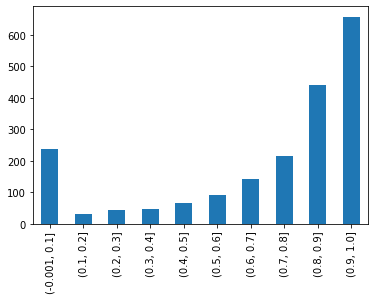

In [19]:
series.value_counts().sort_index().plot('bar')